# Modelo de precio fundamental (fair value) USDCOP

Integrantes:

1. Santiago Echeverri Calderon - sechev11@eafit.edu.co
2. Edgar Leandro Jimenez - eljimenezj@eafit.edu.co
3. Jorge Luis Renteria - jlrenteria@eafit.edu.co
4. Luis Rodgrigo Vesga - lrvesga@eafit.edu.co
5. Alvaro Villa - avillav2@eafit.edu.co

Universidad Eafit, 2020.

El análisis fundamental estudia factores macroeconómicos con el fin de conocer su influencia en los precios de un activo financiero.  La premisa principal de este análisis es que el precio de un activo puede diferir de su valor de mercado, en otras palabras, que el precio de mercado puede estar en ocasiones sobrevalorado o subvalorado.  Bajo esta premisa también se espera que el precio de mercado tenderá a acercarse a su valor autentico o fundamental (Fair Value).

El propósito de este Notebook es obtener un modelo de precio fundamental para la divisa USDCOP, el cual hace parte del proyecto integrador 

## Librerias

In [0]:
import pandas as pd
import glob
import re
import numpy as np
import time
from google.colab import drive
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [0]:
# ---------------------------------------------------------------
# Ahora realizamos la autenticacion necesaria para Google Drive
# e ir a buscar los datos almacenados, esto debe realizare cada vez
# que se reinicie el Colab 
# ----------------------------------------------------------------
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Funciones

In [0]:
def leer_fundamentales(pathDF,DFname,v_name,skip=5):
  datatemp=pd.read_excel(pathDF+DFname,sheet_name=v_name,skiprows=skip)
  datatemp=datatemp.iloc[2:]
  datatemp.rename(columns={"Unnamed: 0": "Dates"},inplace = True)
  return datatemp

In [0]:
def leer_precios(pathDF,DFname,v_name,skip=5):
  datatemp=pd.read_excel(pathDF+DFname,sheet_name=v_name,skiprows=skip)
  datatemp=datatemp.iloc[1:]
  #datatemp['Dates']=[pd.to_datetime(datetime.fromtimestamp((int(fecha)-25569)*86400).strftime("%d%m%Y"),format='%d%m%Y') for fecha in list(datatemp['Dates'])]
  return datatemp

## Carga de los datos

In [0]:
# Path Colab
pathDF= '/content/drive/My Drive/PI 2020-1/Datasets/Dataset_Nuevo/' 
# Path Jupyter
#pathDF= '../Datasets/Dataset_Nuevo/' 

In [0]:
# Carga información de fundamentales
DFname= 'VariablesFXModel_FD.xlsx'

# COP fundamentales
df= leer_fundamentales(pathDF,DFname,'COP_F',3)
# COP mercado
df = df.merge(leer_fundamentales(pathDF,DFname,'COP_M',3),left_on='Dates',right_on='Dates')
# COP indices
df = df.merge(leer_fundamentales(pathDF,DFname,'COP_I',3),left_on='Dates',right_on='Dates')
# USD fundamentales
df= df.merge(leer_fundamentales(pathDF,DFname,'USD_F',3),left_on='Dates',right_on='Dates')
# USD mercado
df = df.merge(leer_fundamentales(pathDF,DFname,'USD_M',3),left_on='Dates',right_on='Dates')
# USD indices
df = df.merge(leer_fundamentales(pathDF,DFname,'USD_I',3),left_on='Dates',right_on='Dates')
# Emergentes fundamentales
df= df.merge(leer_fundamentales(pathDF,DFname,'EM_F',3),left_on='Dates',right_on='Dates')
# Emergentes mercado
df = df.merge(leer_fundamentales(pathDF,DFname,'EM_M',3),left_on='Dates',right_on='Dates')
# Emergentes indices
df = df.merge(leer_fundamentales(pathDF,DFname,'EM_I',3),left_on='Dates',right_on='Dates')
# General fundamentales
df= df.merge(leer_fundamentales(pathDF,DFname,'General_F',3),left_on='Dates',right_on='Dates')
# General mercado
df = df.merge(leer_fundamentales(pathDF,DFname,'General_M',3),left_on='Dates',right_on='Dates')
# General indices
df = df.merge(leer_fundamentales(pathDF,DFname,'General_I',3),left_on='Dates',right_on='Dates')

df = df.infer_objects()
df['Dates']= pd.to_datetime(df['Dates'])

# Carga de precios diarios
DFname= 'Base de Datos FX _FD.xlsx'
v_name='USDCOP'

Y = leer_precios(pathDF,DFname, v_name,5)
Y = Y[['Dates','PX_LAST']]
Y = Y.infer_objects()

# Combinar datasets
df = df.merge(Y,left_on='Dates',right_on='Dates')

# Definir la fecha como índice
df.set_index('Dates', inplace=True)

print(df.shape)
#df.head(1)

(5274, 94)


Validar y borrar columnas con la misma información

In [0]:
def getDuplicateColumns(df):
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

In [0]:
duplicateColumnNames = getDuplicateColumns(df)
df = df.drop(columns=getDuplicateColumns(df))
print("Columnas duplicadas borradas: ", duplicateColumnNames)

Columnas duplicadas borradas:  ['FDTR Index.1', 'USDCOPV3M Curncy.1', 'COLOM CDS USD SR 5Y D14 Curncy.1', 'CORRRMIN Index', 'USDCOP25R1M Curncy.1', 'COTRIMPM INDEX_y']


Filtrar las columnas que contengan información desde una fecha específica

In [0]:
# Obtener la primera fecha con información de cada columna
fechas_info = df.apply(pd.Series.first_valid_index)
# Encontrar variables con información para una fecha
fecha_objetivo = '2006-04-01'
seleccion = fechas_info.loc[lambda x : x <= fecha_objetivo]
exclusion = fechas_info.loc[lambda x : x > fecha_objetivo]
print('Variables con información desde', fecha_objetivo, ':', seleccion.size)

# Borrar variables sin informacion desde la fecha objetivo
df_filtrado = df.drop(list(exclusion.index.values),axis=1)

Variables con información desde 2006-04-01 : 78


Exportar el dataset consolidado

In [0]:
df_filtrado.to_excel('/content/drive/My Drive/PI 2020-1/Datasets/Dataset_Nuevo/FX_consolidado.xlsx')

## Exploracion de Variables

### Correlación con la variable de predicción Y

In [0]:
importances = df_filtrado.drop('PX_LAST', axis=1).apply(lambda x: x.corr(df_filtrado.PX_LAST))
indices = np.argsort(importances)
print(importances[indices].head(5),importances[indices].tail(5))
#importances.to_excel('/content/drive/My Drive/PI 2020-1/Datasets/importances.xlsx')

CHLR12MC INDEX   -0.808427
CNRSACMY Index   -0.683829
BCOM Index       -0.676252
CNRSCYOY Index   -0.673825
JFRIEM Index     -0.605695
dtype: float64 COEXPRIV INDEX    0.543638
CONSCURR INDEX    0.564137
COMFCOMF INDEX    0.571691
SPX index         0.591293
BJACTOTL INDEX    0.750321
dtype: float64


In [0]:
# Borrar variables con alta correlación con Y
'''
drop_features = ['BJACTOTL INDEX','CHLR12MC INDEX']
df_filtrado = df_filtrado.drop(columns=drop_features)
df_filtrado.shape
'''

"\ndrop_features = ['BJACTOTL INDEX','CHLR12MC INDEX']\ndf_filtrado = df_filtrado.drop(columns=drop_features)\ndf_filtrado.shape\n"

### Correlación entre variables predictoras

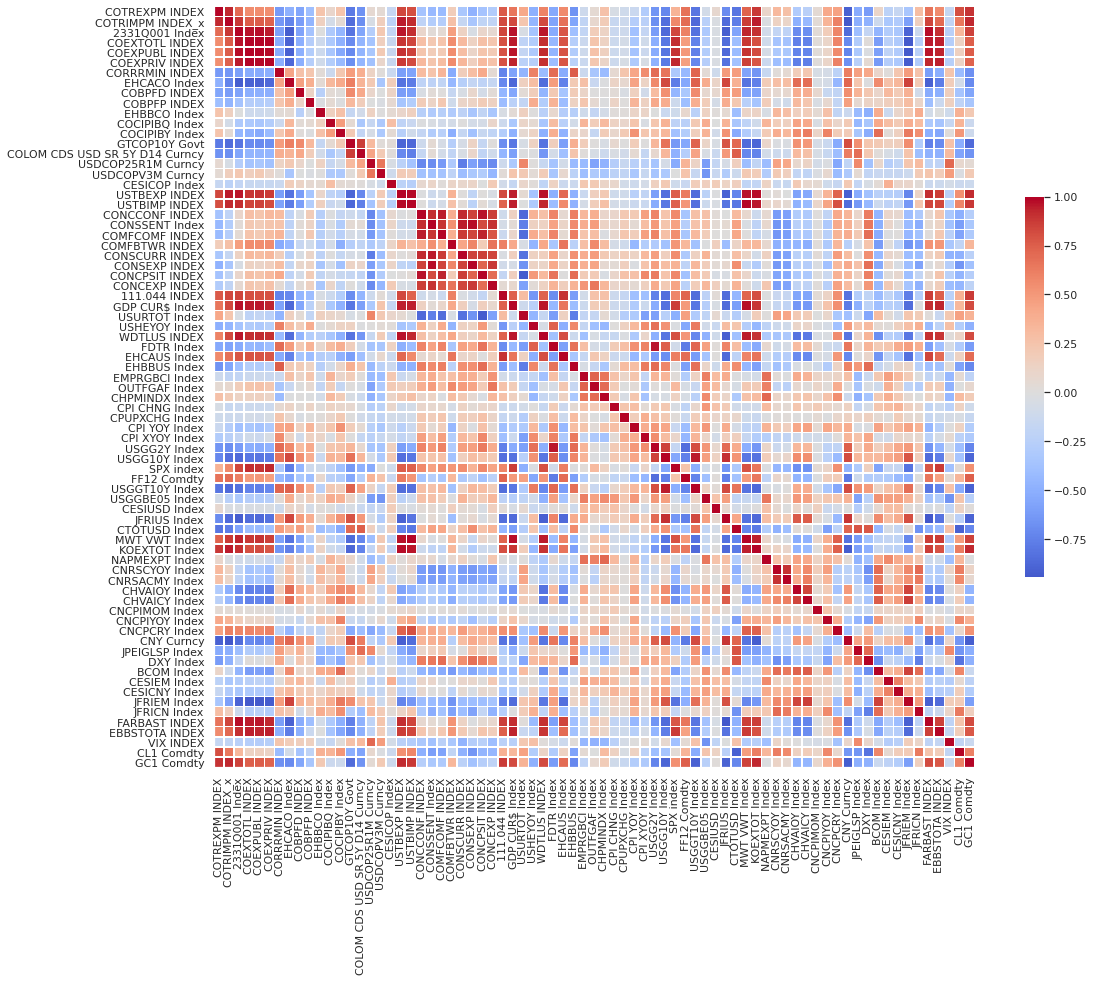

In [0]:
import seaborn as sns
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
corr = df_filtrado.drop(['PX_LAST'], axis=1).corr()
g = sns.heatmap(corr,  center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                fmt='.1f', cmap='coolwarm', xticklabels=True, yticklabels=True) #annot=True
sns.despine()
g.figure.set_size_inches(18,14)

In [0]:
# Matriz de correlación absoluta
corr_matrix = df_filtrado.drop(['PX_LAST'], axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.to_excel('/content/drive/My Drive/PI 2020-1/Datasets/correlacion_upper.xlsx')
corr_matrix.to_excel('/content/drive/My Drive/PI 2020-1/Datasets/correlacion.xlsx')

In [0]:
# Borrado de variables con alta correlación
'''
threshold = 0.90

#collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]
#print("Variables con alta colinealidad: ", len(collinear_features))
#print(collinear_features)
'''
# Atributos con alta colinealidad seleccionados manualmente
collinear_features = ['2331Q001 Index', 'COEXTOTL INDEX', 'USTBEXP INDEX', 'GDP CUR$ Index', 'WDTLUS INDEX', 'FARBAST INDEX', 'USTBIMP INDEX', 'KOEXTOT Index', 'COTRIMPM INDEX_x',   'FDTR Index', 'COCIPIBY Index', 'EHBBUS Index', 'VIX INDEX', 'COCIPIBQ Index', 'SPX index', '111.044 INDEX', 'COEXPRIV INDEX', 'CHVAIOY Index', 'CNCPIYOY Index', 'CESIEM Index', 'CESICOP Index'] #'COEXTOTL INDEX','COCIPIBQ Index' #'COEXPUBL INDEX', 'COCIPIBQ Index', 'COCIPIBY Index', 'CONCCONF INDEX', 'CONSEXP INDEX', 'CONCPSIT INDEX', 'USHEYOY Index', 'WDTLUS INDEX', 'OUTFGAF Index', 'USGG2Y Index', 'MWT VWT Index', 'KOEXTOT Index', 'CESICNY Index'
df_filtrado = df_filtrado.drop(columns=collinear_features)
df_filtrado.shape

(5274, 57)

Factor de inflación de la varianza

In [0]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)
pd.options.display.float_format = '{:.2f}'.format
VIF = calc_vif(df_filtrado.drop(['PX_LAST'], axis=1).loc['2006-04-01':'2019-06-30'] )
VIF

,variables,VIF
0,COTREXPM INDEX,249.14
1,COEXPUBL INDEX,6483.05
2,CORRRMIN INDEX,304.74
3,EHCACO Index,252.06
4,COBPFD INDEX,8.45
5,COBPFP INDEX,4.55
6,EHBBCO Index,8.30
7,GTCOP10Y Govt,606.95
8,COLOM CDS USD SR 5Y D14 Curncy,138.48
9,USDCOP25R1M Curncy,40.48


### Partición de los datos en train y test

In [0]:
# Opción1: partición secuencial por fecha (train y test)
train = df_filtrado.loc['2006-04-01':'2019-06-30']  #['2006-04-01':'2018-12-31']
test = df_filtrado.loc['2019-10-01':'2020-02-29']

X_train = train.drop('PX_LAST',axis=1)
X_test = test.drop('PX_LAST',axis=1)
y_train = train['PX_LAST']
y_test = test['PX_LAST']

print("Nulos en train: ",train.isnull().values.any())
print("Nulos en test: ",test.isnull().values.any())

print("Valores X train: ",X_train.shape)
print("Valores y train: ",y_train.shape)
print("Valores X test: ",X_test.shape)
print("Valores y test: ",y_test.shape)

Nulos en train:  False
Nulos en test:  False
Valores X train:  (3421, 56)
Valores y train:  (3421,)
Valores X test:  (108, 56)
Valores y test:  (108,)


In [0]:
# Opcion2: partición secuencial por fecha (train/validation y test)

df_filtrado['periodo'] = df_filtrado.index.strftime("%Y-%m")

# Datos para entrenamiento y optimización
train = df_filtrado.loc['2006-04-01':'2019-06-30']
X_train, X_val, y_train, y_val = train_test_split(train.drop(['PX_LAST','periodo'],axis=1), train['PX_LAST'], test_size=0.2, random_state=42, stratify=train['periodo'])

# Datos para test
test = df_filtrado.loc['2019-07-01':'2020-02-29']
X_test = test.drop(['PX_LAST','periodo'],axis=1)
y_test = test['PX_LAST']

print("Nulos en train: ",train.isnull().values.any())
print("Nulos en test: ",test.isnull().values.any())

print("Valores X test: ",X_test.shape)
print("Valores y test: ",y_test.shape)

Nulos en train:  False
Nulos en test:  False
Valores X test:  (174, 56)
Valores y test:  (174,)


## Preprocesamiento

### Normalización de los datos

In [0]:
columnas = df_filtrado.columns
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler.fit_transform(X_train)
y_scaler.fit_transform(y_train.values.reshape(-1, 1))

X_train_sc = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns)
y_train_sc = pd.DataFrame(y_scaler.transform(y_train.values.reshape(-1, 1)))
y_test_sc = pd.DataFrame(y_scaler.transform(y_test.values.reshape(-1, 1)))


X_val_sc = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns)
y_val_sc = pd.DataFrame(y_scaler.transform(y_val.values.reshape(-1, 1)))
X_train_FULL_sc = pd.DataFrame(X_scaler.transform(train.drop(['PX_LAST','periodo'],axis=1)), columns=X_train.columns)
y_train_FULL_sc = pd.DataFrame(y_scaler.transform(train['PX_LAST'].values.reshape(-1, 1)))


desviacion_y = np.sqrt(y_scaler.var_)

print("y media: ",y_scaler.mean_)
print("y desviación est.: ",np.sqrt(y_scaler.var_))

y media:  [2316.23388158]
y desviación est.:  [502.63101142]


## Modelos de regresión

### Modelo 1: Regresión Lineal Base

In [0]:
modelo1 = LinearRegression().fit(X_train_sc, y_train_sc)
y_pred_train =  y_scaler.inverse_transform(modelo1.predict(X_train_sc))
y_pred_test = y_scaler.inverse_transform(modelo1.predict(X_test_sc))
print("R2 train: ",round(modelo1.score(X_train_sc, y_train_sc),3))
print("RMSE train: ", round(mean_squared_error(y_train, y_pred_train, squared=False),2))
print('-----------------------')
print("R2 test: ",round(modelo1.score(X_test_sc, y_test_sc),3))
print("RMSE test: ", round(mean_squared_error(y_test, y_pred_test, squared=False),2))

R2 train:  0.991
RMSE train:  49.05
-----------------------
R2 test:  0.519
RMSE test:  47.78


Predicciones en los datos de prueba

In [0]:
resultado_df = pd.DataFrame({'Fecha':y_test.index, 'Real': y_test.values, 'Prediccion': y_pred_test.flatten()})
resultado_df['Diferencia'] = resultado_df['Real'] - resultado_df['Prediccion'] 
resultado_df['Diferencia sigma'] = resultado_df['Diferencia']/desviacion_y
resultado_df['Diferencia %'] = resultado_df['Diferencia']/resultado_df['Real']
resultado_df.to_excel('/content/drive/My Drive/PI 2020-1/Datasets/Dataset_Nuevo/test_modelo1.xlsx')
resultado_df


,Fecha,Real,Prediccion,Diferencia,Diferencia sigma,Diferencia %
0,2019-10-01,3496.91,3460.69,36.22,0.07,0.01
1,2019-10-02,3495.87,3468.12,27.75,0.06,0.01
2,2019-10-03,3450.80,3469.61,-18.81,-0.04,-0.01
3,2019-10-04,3435.17,3469.75,-34.58,-0.07,-0.01
4,2019-10-07,3451.85,3466.04,-14.19,-0.03,-0.00
...,...,...,...,...,...,...
152,2020-05-04,3987.70,4199.17,-211.47,-0.42,-0.05
153,2020-05-05,3933.53,4170.90,-237.37,-0.47,-0.06
154,2020-05-06,3964.24,4173.34,-209.10,-0.42,-0.05
155,2020-05-07,3924.03,4159.52,-235.49,-0.47,-0.06


Resultado de la regresión

In [0]:
X2 = sm.add_constant(X_train_sc)
est = sm.OLS(y_train_sc, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     6270.
Date:                Mon, 25 May 2020   Prob (F-statistic):               0.00
Time:                        17:54:57   Log-Likelihood:                 3112.4
No. Observations:                3421   AIC:                            -6111.
Df Residuals:                    3364   BIC:                            -5761.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [0]:
# Exportar dataset
data = df_filtrado.loc['2006-04-01':'2020-05-08']
X_data = data.drop(['PX_LAST','periodo'],axis=1)
y_data = data['PX_LAST']
X_data_sc = pd.DataFrame(X_scaler.transform(X_data), columns=X_data.columns)
y_data_sc = pd.DataFrame(y_scaler.transform(y_data.values.reshape(-1, 1)))

prediccion = y_scaler.inverse_transform(modelo1.predict(X_data_sc))
resultado_df = pd.DataFrame({'Fecha':y_data.index, 'Real': y_data.values, 'Prediccion': prediccion.flatten()})
resultado_df['Diferencia'] = resultado_df['Real'] - resultado_df['Prediccion'] 
resultado_df['Diferencia sigma'] = resultado_df['Diferencia']/desviacion_y
resultado_df
#resultado_df.to_excel('/content/drive/My Drive/PI 2020-1/Datasets/Dataset_Nuevo/test_completo.xlsx')

In [0]:
resultado_vars = resultado_df.merge(X_data, left_on='Fecha', right_index=True)
resultado_vars = resultado_vars.drop(['Real','Prediccion','Diferencia'],axis=1)
resultado_vars.to_excel('/content/drive/My Drive/PI 2020-1/Datasets/Dataset_Nuevo/Fundamentales.xlsx', index=False)

### Modelo 2: Regresión con Regularización


Optimización alpha y ratio regularización ElasticNet

In [0]:
# Calcular errores de train y test buscando optimizar alpha y ratio L1
alphas= np.logspace(-5, 1, 100)
l1_ratios = np.linspace(0, 1, 20)
enet = ElasticNet(l1_ratio=0.6, max_iter=1000, random_state=42)
train_r2 = list()
val_r2 = list()
train_rmse = list()
val_rmse = list()
params = list()
for alpha in alphas:
  for ratio in l1_ratios:  
    enet.set_params(alpha=alpha, l1_ratio=ratio)
    enet.fit(X_train_sc, y_train_sc)
    # Optimizacion de R2
    train_r2.append(enet.score(X_train_sc, y_train_sc))
    val_r2.append(enet.score(X_val_sc, y_val_sc))
    # Optimizacion de RMSE
    y_pred_train = y_scaler.inverse_transform(enet.predict(X_train_sc))
    y_pred_val = y_scaler.inverse_transform(enet.predict(X_val_sc))
    train_rmse.append(mean_squared_error(y_train, y_pred_train, squared=False))
    val_rmse.append(mean_squared_error(y_val, y_pred_val, squared=False)) 
    # Almacenar parametros
    params.append([alpha,ratio])

# Optimizacion R2
best_r2_idx = np.argmax(val_r2)
# Optimizacion RMSE
best_rmse_idx = np.argmin(val_rmse)

best_params_r2 = params[best_r2_idx]
best_params_rmse = params[best_rmse_idx]
print(val_r2[best_r2_idx])
print(val_rmse[best_rmse_idx])

0.9909227026138945
48.293414691277015


In [0]:
# Estimar coeficientes con el mejor alpha y ratio
enet.set_params(alpha=best_params_rmse[0], l1_ratio=best_params_rmse[1], random_state = 42 )
enet.fit(X_train_FULL_sc, y_train_FULL_sc)
y_pred_train = y_scaler.inverse_transform(enet.predict(X_train_FULL_sc))
y_pred_test = y_scaler.inverse_transform(enet.predict(X_test_sc))

print("Mejor alpha : ","{:.2E}".format(best_params_r2[0]))
print("Mejor ratio l1 : ",best_params_r2[1])
print('-----------------------')
print("R2 train completo (train+val): ",round(enet.score(X_train_FULL_sc, y_train_FULL_sc),3))
print("RMSE train completo (train+val): ", round(mean_squared_error(train['PX_LAST'], y_pred_train, squared=False),2))
print('-----------------------')
print("R2 test: ",round(enet.score(X_test_sc, y_test_sc),3))
print("RMSE test: ", round(mean_squared_error(y_test, y_pred_test, squared=False),2))

Mejor alpha :  2.15E-04
Mejor ratio l1 :  1.0
-----------------------
R2 train completo (train+val):  0.99
RMSE train completo (train+val):  50.26
-----------------------
R2 test:  -0.12
RMSE test:  275.26


Predicciones en datos de pruebas

In [0]:
resultado_df2 = pd.DataFrame({'Fecha':y_test.index, 'Real': y_test.values, 'Prediccion': y_pred_test.flatten()})
resultado_df2['Diferencia'] = resultado_df2['Prediccion'] - resultado_df2['Real']
resultado_df2['Diferencia sigma'] = resultado_df2['Diferencia']/desviacion_y
resultado_df2['Diferencia %'] = resultado_df2['Diferencia']/resultado_df2['Real']
#resultado_df2.to_excel('/content/drive/My Drive/PI 2020-1/Datasets/Dataset_Nuevo/test_enet.xlsx')
resultado_df2

,Fecha,Real,Prediccion,Diferencia,Diferencia sigma,Diferencia %
0,2019-07-01,3207.33,3295.638698,88.308698,0.175693,0.027533
1,2019-07-02,3210.66,3307.699053,97.039053,0.193062,0.030224
2,2019-07-03,3196.30,3299.010556,102.710556,0.204346,0.032134
3,2019-07-04,3201.56,3295.990552,94.430552,0.187873,0.029495
4,2019-07-05,3211.76,3300.309599,88.549599,0.176172,0.027570
...,...,...,...,...,...,...
169,2020-02-24,3429.21,3580.468544,151.258544,0.300934,0.044109
170,2020-02-25,3435.86,3583.303812,147.443812,0.293344,0.042913
171,2020-02-26,3459.51,3599.094856,139.584856,0.277708,0.040348
172,2020-02-27,3501.63,3616.260623,114.630623,0.228061,0.032736


In [0]:
# Coeficientes de la regresión ElasticNet
coef_dict = {}
for coef, feat in zip(enet.coef_,X_train_sc.columns):
    coef_dict[feat] = coef
coef_dict

### Modelo 3: Regresión Random Forest


In [0]:
RF = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=0)
RF.fit(X_train_FULL_sc, y_train_FULL_sc)
y_pred_train = y_scaler.inverse_transform(model.predict(X_train_FULL_sc))
y_pred_test = y_scaler.inverse_transform(model.predict(X_test_sc))
print("R2 train: ",RF.score(X_train_sc, y_train_sc))
print("R2 test: ",RF.score(X_test_sc, y_test_sc))
print("RMSE train completo (train+val): ", round(mean_squared_error(train['PX_LAST'], y_pred_train, squared=False),2))
print("RMSE test: ", round(mean_squared_error(y_test, y_pred_test, squared=False),2))

R2 train:  0.9997389249618346
R2 test:  -4.4679236100221456
RMSE train completo (train+val):  7.25
RMSE test:  206.49


In [0]:
Md_model = range(5,20)
Ne_model = range(100,180,20)
train_rmse = list()
val_rmse = list()
params = list()

for Ne in Ne_model:
  for Md in Md_model:
      model = RandomForestRegressor(n_estimators=Ne,max_depth=Md, random_state = 42 )
      model.fit(X_train_sc, y_train_sc)
      # Optimizacion de RMSE
      y_pred_train = y_scaler.inverse_transform(model.predict(X_train_sc))
      y_pred_val = y_scaler.inverse_transform(model.predict(X_val_sc))
      train_rmse.append(mean_squared_error(y_train, y_pred_train, squared=False))
      val_rmse.append(mean_squared_error(y_val, y_pred_val, squared=False))
      params.append([Ne,Md])

# Mejor RMSE
best_rmse_idx = np.argmin(val_rmse)
best_params_rmse = params[best_rmse_idx]

print(val_rmse[best_rmse_idx])

17.832093109403118


In [0]:
# Estimar coeficientes con el mejor alpha y ratio
model.set_params(n_estimators=best_params_rmse[0], max_depth=best_params_rmse[1], random_state = 42 )
model.fit(X_train_FULL_sc, y_train_FULL_sc)
y_pred_train = y_scaler.inverse_transform(model.predict(X_train_FULL_sc))
y_pred_test = y_scaler.inverse_transform(model.predict(X_test_sc))

print("Mejor n estimadores: ","{:.2E}".format(best_params_rmse[0]))
print("Mejor profunidad : ",best_params_rmse[1])
print('-----------------------')
print("R2 train completo (train+val): ",round(model.score(X_train_FULL_sc, y_train_FULL_sc),3))
print("RMSE train completo (train+val): ", round(mean_squared_error(train['PX_LAST'], y_pred_train, squared=False),2))
print('-----------------------')
print("R2 test: ",round(model.score(X_test_sc, y_test_sc),3))
print("RMSE test: ", round(mean_squared_error(y_test, y_pred_test, squared=False),2))

Mejor n estimadores:  1.00E+02
Mejor profunidad :  18
-----------------------
R2 train completo (train+val):  1.0
RMSE train completo (train+val):  7.25
-----------------------
R2 test:  -4.727
RMSE test:  206.49
